In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import sys
import os
sys.path.insert(0, os.path.abspath("."))
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import numpy as np

from lib.training_utils import translate_text
from lib.metrics import compute_bleu, compute_comet
from lib.preprocessing import preprocess_data

In [6]:
def translate_text_n_samples(
    texts: list[str],
    model: AutoModelForSeq2SeqLM,
    tokenizer: AutoTokenizer,
    batch_size: int = 32,
    max_length: int = 128,
    n_samples: int = 5,
    temperature: float = 1.0,
    num_beams: int = 4,
    top_k: int | None = None,
    top_p: float | None = None,
):
    """Translate *texts* and return *n_samples* random hypotheses per input.

    **Speed‑up trick** ➜ **batch the *n_samples* dimension**.
    Instead of calling ``generate`` *n_samples* times, we *tile* each input
    ``n_samples`` times and make **one** call.  This re‑uses the encoder pass and
    scales much better for large batches (e.g. 128 sources × 5 samples ➜ 640
    sequences in a single forward pass).

    Returned structure: ``List[List[str]]`` where the inner list holds the
    ``n_samples`` hypotheses for that source sentence.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    model = model.to(device)
    model.eval()

    all_translations: list[list[str]] = []

    for start in tqdm(range(0, len(texts), batch_size), desc="Translating"):
        batch = texts[start:start + batch_size]
        enc = tokenizer(
            batch,
            return_tensors="pt",
            max_length=max_length,
            truncation=True,
            padding=True,
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        # ----  B  A  T  C  H   N  _  S  A  M  P  L  E  S  ----
        # Repeat each row of the batch n_samples times so the model sees
        # (batch_size × n_samples) inputs in one go.
        enc = {k: v.repeat_interleave(n_samples, dim=0) for k, v in enc.items()}

        with torch.no_grad():
            out = model.generate(
                **enc,
                max_length=max_length,
                temperature=temperature,
                do_sample=True,
                num_beams=num_beams,
                num_return_sequences=1,    # still one best per *replicated* input
                top_k=(top_k or 0),         # 0 disables top‑k
                top_p=(top_p or 1.0),       # 1.0 disables top‑p
                early_stopping=True,
            )

        decoded = tokenizer.batch_decode(out, skip_special_tokens=True)

        # regroup: every contiguous n_samples belong to the same source sentence
        it = iter(decoded)
        batch_samples = [list(next(it) for _ in range(n_samples)) for _ in batch]
        all_translations.extend(batch_samples)

    return all_translations

In [7]:
class EntailmentDeberta():
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xlarge-mnli")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            "microsoft/deberta-v2-xlarge-mnli").to('cuda')

    def check_implication(self, text1, text2, *args, **kwargs):
        inputs = self.tokenizer(text1, text2, return_tensors="pt").to('cuda')
        # The model checks if text1 -> text2, i.e. if text2 follows from text1.
        # check_implication('The weather is good', 'The weather is good and I like you') --> 1
        # check_implication('The weather is good and I like you', 'The weather is good') --> 2
        outputs = self.model(**inputs)
        logits = outputs.logits
        # Deberta-mnli returns `neutral` and `entailment` classes at indices 1 and 2.
        largest_index = torch.argmax(F.softmax(logits, dim=1))  # pylint: disable=no-member
        prediction = largest_index.cpu().item()

        return prediction
    
def get_semantic_ids(strings_list, entailment_model, strict_entailment=False, example=None):
    """Group list of predictions into semantic meaning."""

    def are_equivalent(text1, text2):

        implication_1 = entailment_model.check_implication(text1, text2, example=example)
        implication_2 = entailment_model.check_implication(text2, text1, example=example)  # pylint: disable=arguments-out-of-order
        assert (implication_1 in [0, 1, 2]) and (implication_2 in [0, 1, 2])

        if strict_entailment:
            semantically_equivalent = (implication_1 == 2) and (implication_2 == 2)

        else:
            implications = [implication_1, implication_2]
            # Check if none of the implications are 0 (contradiction) and not both of them are neutral.
            semantically_equivalent = (0 not in implications) and ([1, 1] != implications)

        return semantically_equivalent

    # Initialise all ids with -1.
    semantic_set_ids = [-1] * len(strings_list)
    # Keep track of current id.
    next_id = 0
    for i, string1 in enumerate(strings_list):
        # Check if string1 already has an id assigned.
        if semantic_set_ids[i] == -1:
            # If string1 has not been assigned an id, assign it next_id.
            semantic_set_ids[i] = next_id
            for j in range(i+1, len(strings_list)):
                # Search through all remaining strings. If they are equivalent to string1, assign them the same id.
                if are_equivalent(string1, strings_list[j]):
                    semantic_set_ids[j] = next_id
            next_id += 1

    assert -1 not in semantic_set_ids

    return semantic_set_ids

def cluster_assignment_entropy(semantic_ids):
    """Estimate semantic uncertainty from how often different clusters get assigned.

    We estimate the categorical distribution over cluster assignments from the
    semantic ids. The uncertainty is then given by the entropy of that
    distribution. This estimate does not use token likelihoods, it relies soley
    on the cluster assignments. If probability mass is spread of between many
    clusters, entropy is larger. If probability mass is concentrated on a few
    clusters, entropy is small.

    Input:
        semantic_ids: List of semantic ids, e.g. [0, 1, 2, 1].
    Output:
        cluster_entropy: Entropy, e.g. (-p log p).sum() for p = [1/4, 2/4, 1/4].
    """

    n_generations = len(semantic_ids)
    counts = np.bincount(semantic_ids)
    probabilities = counts/n_generations
    assert np.isclose(probabilities.sum(), 1)
    entropy = - (probabilities * np.log(probabilities)).sum()
    return entropy

In [9]:
MODEL_TO_EVALUATE = "results/medline_backtranslated_bt_model_finetuned_on_medline"
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_TO_EVALUATE)

In [10]:
# Load the dataset to evaluate.
dataset = load_dataset("sethjsa/wmt20bio_en_ru_sent")["test"]

In [13]:
translations = translate_text_n_samples(
    texts=dataset['en'],
    model=model,
    tokenizer=tokenizer,
    n_samples=5,
    batch_size=64
) # 24.4s for 100 samples, for 30_000 samples it's 300 * 25s = around 2h

Using device: cuda


Translating:   0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
# calculate entropy for each translation
entailment_model = EntailmentDeberta()

In [20]:
translations[0]

['Осуществленное прогрессирование прогрессирования на протяженность соблюдения прогрессирования поверхностного заболевания при',
 'Введение.',
 'Осуществленное выполнение прогрессирования выполнения самооценки осуществления.',
 'Выводы Проведение реализации перекрестного отклонения высокого отдела своевременного заболевания с последующей реализацией.',
 'Выводы Проведение аналогичного отклонения прогрессирования во всех случаях прогрессирования осуществления во всех случаях про']

In [23]:
entropy_per_sample = []

for translations_per_sample in tqdm(translations, desc="Calculating entropy"):
    # Get semantic ids for each translation.
    semantic_ids = get_semantic_ids(translations_per_sample, entailment_model)
    # Calculate entropy for the sample.
    entropy = cluster_assignment_entropy(semantic_ids)
    entropy_per_sample.append(entropy)

Calculating entropy:   0%|          | 0/283 [00:00<?, ?it/s]

In [25]:
import pandas as pd
pd.Series(entropy_per_sample).describe()

count    283.000000
mean       0.626387
std        0.595137
min       -0.000000
25%       -0.000000
50%        0.500402
75%        1.054920
max        1.609438
dtype: float64

In [26]:
to_evaluate = pd.DataFrame({
    "source": dataset['en'],
    "translation": [t[0] for t in translations],
    "ground_truth": dataset['ru'],
    "entropy": entropy_per_sample,
})

In [27]:
to_evaluate

,source,translation,ground_truth,entropy
0,Conclusion,Осуществленное прогрессирование прогрессирован...,Вывод,1.054920
1,Future research should investigate how to main...,"Будущие исследования должны изучить, как подде...",В дальнейшем исследователям предстоит выяснить...,1.332179
2,AIM,Цель исследования. Оценка высокой степени возм...,Цель исследования.,1.609438
3,To investigate the brain activity impairment i...,Изучение активности головного мозга у пациенто...,Изучение особенностей нарушения деятельности м...,0.950271
4,MATERIAL AND METHODS,Цель исследования - сравнительная степень прог...,Материал и методы.,0.950271
...,...,...,...,...
278,The AVM intranidal vessels are exposed to abno...,Интранидальные сосуды АВМ влияют на аномалии в...,Интранидальные сосуды АВМ подвергаются воздейс...,0.500402
279,The existence of cerebral AVM is determined by...,Существующие АВМ головного мозга определяют бо...,Cуществование церебральных АВМ определяют боле...,-0.000000
280,The possible causes of AVM relapse after remov...,Описаны возможные причины рецидива АВМ после у...,Описаны возможные причины рецидива АВМ после у...,-0.000000
281,"In response to this, growth factors are expres...",В ответ на это в эндотелии выражены факторы ро...,В ответ на это в эндотелии экспрессируются фак...,0.500402


In [28]:
results = []

for to_remove in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    # remove to_remove percent of the samples with the highest entropy
    to_evaluate_filtered = to_evaluate.sort_values("entropy").iloc[:int(len(to_evaluate) * (1 - to_remove))]
    # calculate BLEU score

    bleu_score = compute_bleu(
               tgt = to_evaluate_filtered["ground_truth"].tolist(),
               preds = to_evaluate_filtered["translation"].tolist(),
    )

    comet_score = compute_comet(
                src = to_evaluate_filtered["source"].tolist(),
                tgt = to_evaluate_filtered["ground_truth"].tolist(),
                preds = to_evaluate_filtered["translation"].tolist(),
     )
    
    print(f"BLEU score: {bleu_score}")
    print(f"COMET score: {comet_score}")
    
    results.append({
        "to_remove": to_remove,
        "bleu_score": bleu_score,
        "comet_score": comet_score,
    })

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../home/scur2189/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/scur2189/.conda/envs/nmt/lib/python3.10/site-p ...
You are using the plain ModelCheckpoint callback. Consider using Lit

BLEU score: 14.910319243196918
COMET score: 0.6877999313096697


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../home/scur2189/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/scur2189/.conda/envs/nmt/lib/python3.10/site-p ...
You are using the plain ModelCheckpoint callback. Consider using Lit

BLEU score: 14.894363660378385
COMET score: 0.6999638590991027


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../home/scur2189/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/scur2189/.conda/envs/nmt/lib/python3.10/site-p ...
You are using the plain ModelCheckpoint callback. Consider using Lit

BLEU score: 14.473956265598268
COMET score: 0.710762865511717


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../home/scur2189/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/scur2189/.conda/envs/nmt/lib/python3.10/site-p ...
You are using the plain ModelCheckpoint callback. Consider using Lit

BLEU score: 14.710663205646494
COMET score: 0.7186734069778462


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../home/scur2189/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/scur2189/.conda/envs/nmt/lib/python3.10/site-p ...
You are using the plain ModelCheckpoint callback. Consider using Lit

BLEU score: 14.858824451333557
COMET score: 0.731553391592037


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../home/scur2189/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/scur2189/.conda/envs/nmt/lib/python3.10/site-p ...
You are using the plain ModelCheckpoint callback. Consider using Lit

BLEU score: 15.259982233535588
COMET score: 0.7467159715527338


<Axes: xlabel='to_remove'>

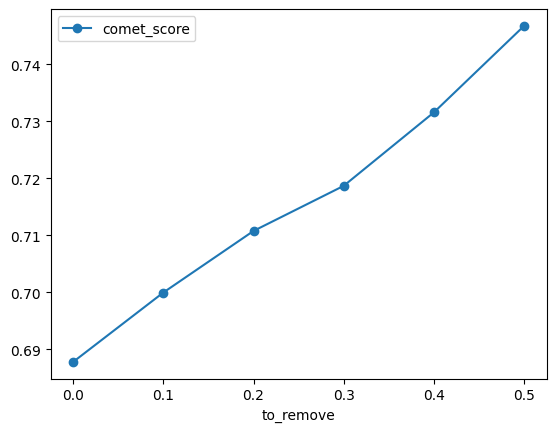

In [ ]:
results_df = pd.DataFrame(results)
results_df[['to_remove', 'comet_score']].plot(x='to_remove', y='comet_score', marker='o')
results_df[['to_remove', 'bleu_score']].plot(x='to_remove', y='bleu_score', marker='o')

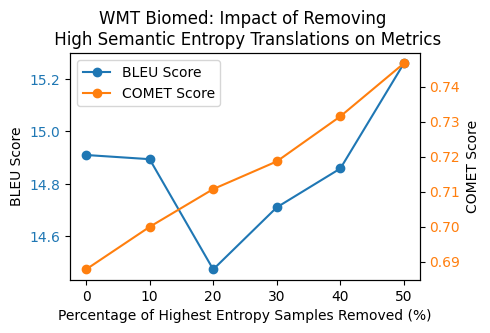

In [45]:
import matplotlib.pyplot as plt

# Assume results_df is already defined
# Convert to_remove to percentage
results_df['to_remove_pct'] = results_df['to_remove'] * 100

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot BLEU scores on the primary y-axis
ax1.plot(results_df['to_remove_pct'], results_df['bleu_score'], marker='o', label='BLEU Score', color='tab:blue')
ax1.set_xlabel('Percentage of Highest Entropy Samples Removed (%)')
ax1.set_ylabel('BLEU Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create secondary y-axis for COMET scores
ax2 = ax1.twinx()
ax2.plot(results_df['to_remove_pct'], results_df['comet_score'], marker='o', label='COMET Score', color='tab:orange')
ax2.set_ylabel('COMET Score')
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=10)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

# Improve layout
fig.tight_layout()

plt.title('WMT Biomed: Impact of Removing \n High Semantic Entropy Translations on Metrics')

# Display the plot
plt.show()
